In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
import queue

In [2]:
class Pose:
    
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        self.cost = np.inf
        self.parent = None
        
    def compute_cost(self, other):
        return np.linalg.norm([self.x - other.x, self.y - other.y, self.theta - other.theta])
    
    def get_neighbors(self, grid, cell_width=0.5):
        ret = []
        
        dx, dy = cell_width * round(np.cos(self.theta)), cell_width * round(np.sin(self.theta)) # compute possible dx, dy based on theta (can only drive straight)
        if (self.x + dx) > 0 and (self.x + dx) < grid.shape[0] * cell_width \
           and (self.y + dy) > 0 and (self.y + dy) < grid.shape[1] * cell_width \
           and grid[int((self.x + dx) / cell_width), int((self.y + dy) / cell_width)] != 1:
            ret.append((self.x + dx, self.y + dy, self.theta))
            
        for t in [0, np.pi/2, np.pi, 3 * np.pi / 2]: # add in turns
            # dx, dy = cell_width * round(np.cos(t)), cell_width * round(np.sin(t))
            # dx2, dy2 = cell_width * round(np.cos(t + np.pi)), cell_width * round(np.sin(t + np.pi))
            if self.theta != t:
            #    and grid[int((self.x + dx) / cell_width), int((self.y + dy) / cell_width)] != 1 \
            #    and grid[int((self.x + dx2) / cell_width), int((self.y + dy2) / cell_width)] != 1:
                ret.append((self.x, self.y, t))

        return ret
                       
    def __lt__(self, other):
        return self.cost < other.cost # for priority queue
    
    def __str__(self):
        return f'({self.x}, {self.y}, {self.theta})'

In [3]:
def visualize(ax, grid, start, goal, path=None, cell_width=0.5):
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(np.arange(0, (grid.shape[0] + 1) * cell_width, cell_width))
    ax.set_yticks(np.arange(0, (grid.shape[1] + 1) * cell_width, cell_width))
    ax.grid()
            
    for i in range(grid.shape[0]): # draw the grid
        for j in range(grid.shape[1]):
            if grid[i,j] == 1:
                ax.add_patch(Rectangle((i * cell_width, j * cell_width),
                                            cell_width,
                                            cell_width,
                                            linewidth=1,
                                            edgecolor='Black',
                                            facecolor='Black'))
    
    ax.add_patch(Rectangle((start.x - 0.25, start.y - 0.25), cell_width, cell_width, # draw start
                           linewidth=1, edgecolor='Red', facecolor='Red'))
    
    ax.add_patch(Rectangle((goal.x - 0.25, goal.y - 0.25), cell_width, cell_width, # draw goal
                           linewidth=1, edgecolor='Green', facecolor='Green'))

    if path != None: # draw the path
        for node in path:
            ax.add_patch(Arrow(node.x,
                               node.y,
                               0.2 * np.cos(node.theta),
                               0.2 * np.sin(node.theta),
                               width=0.6,
                               edgecolor='Blue',
                               facecolor='Blue'))
                
    ax.set_xlabel('x')
    ax.set_ylabel('y')

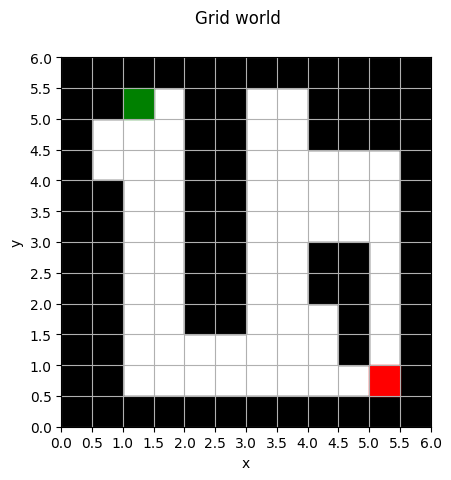

In [4]:
grid = np.array([[1,1,1,1,1,1,1,1,1,1,1,1],
                 [1,1,0,0,1,1,0,0,1,1,1,1],
                 [1,0,0,0,1,1,0,0,1,1,1,1],
                 [1,0,0,0,1,1,0,0,0,0,0,1],
                 [1,1,0,0,1,1,0,0,0,0,0,1],
                 [1,1,0,0,1,1,0,0,0,0,0,1],
                 [1,1,0,0,1,1,0,0,1,1,0,1],
                 [1,1,0,0,1,1,0,0,1,1,0,1],
                 [1,1,0,0,1,1,0,0,0,1,0,1],
                 [1,1,0,0,0,0,0,0,0,1,0,1],
                 [1,1,0,0,0,0,0,0,0,0,0,1],
                 [1,1,1,1,1,1,1,1,1,1,1,1]]).T
grid = np.flip(grid, axis=1) # need to do this to align array indices with requested grid coordinates
start = Pose(5.25, 0.75, 0)
goal = Pose(1.25, 5.25, 0)
fig, ax = plt.subplots()
visualize(ax, grid, start, goal)
fig.suptitle('Grid world')
plt.show()

In [5]:
def waypoint_gen(grid, start, goal):
    """
    Function requested in prelab. Uses Dijkstra's

    Args:
        grid (numpy array): grid description of world, 0 = fresespace and 1 = obstacle
        start (Pose): Pose object for starting location
        goal (Pose): Pose object for requested ending location

    Returns:
        list: list of Pose objects representing the start to goal path if it exists
    """
    point_to_pose = {} # assemble a dictionary relating (x,y,theta) to Pose object (need this to store cost/parent)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            for theta in [0, np.pi/2, np.pi, 3 * np.pi/2]:
                point_to_pose[(x/2 + 0.25,y/2 + 0.25,theta)] = Pose(x/2 + 0.25, y/2 + 0.25, theta)
                
    point_to_pose[(start.x, start.y, start.theta)] = start
    point_to_pose[(goal.x, goal.y, goal.theta)] = goal
    start.cost = start.compute_cost(start)

    onDeck = queue.PriorityQueue()
    onDeck.put(start)
    iters = 0
    while onDeck.empty() != True:
        iters += 1
        node = onDeck.get()
        # print(node)
        if node == goal:
            break
        for neighbor_point in node.get_neighbors(grid):
            neighbor = point_to_pose[neighbor_point]
            new_cost = neighbor.compute_cost(start) + node.cost
            if new_cost < neighbor.cost: # only search if neighbor is 'more optimal'
                neighbor.cost = new_cost
                neighbor.parent = node
                onDeck.put(neighbor)

    node = goal
    path = [goal]
    while node != start: # construct path
        path.append(node.parent)
        node = node.parent
        
    fig, ax = plt.subplots()
    visualize(ax, grid, start, goal, path)
    fig.suptitle('Grid world')
    plt.show()
    return path

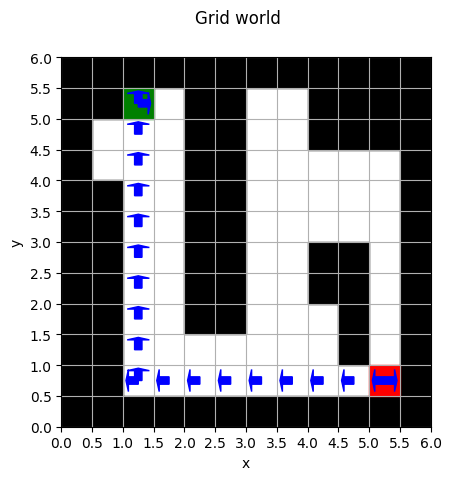

(1.25, 5.25, 0)
(1.25, 5.25, 1.5707963267948966)
(1.25, 4.75, 1.5707963267948966)
(1.25, 4.25, 1.5707963267948966)
(1.25, 3.75, 1.5707963267948966)
(1.25, 3.25, 1.5707963267948966)
(1.25, 2.75, 1.5707963267948966)
(1.25, 2.25, 1.5707963267948966)
(1.25, 1.75, 1.5707963267948966)
(1.25, 1.25, 1.5707963267948966)
(1.25, 0.75, 1.5707963267948966)
(1.25, 0.75, 3.141592653589793)
(1.75, 0.75, 3.141592653589793)
(2.25, 0.75, 3.141592653589793)
(2.75, 0.75, 3.141592653589793)
(3.25, 0.75, 3.141592653589793)
(3.75, 0.75, 3.141592653589793)
(4.25, 0.75, 3.141592653589793)
(4.75, 0.75, 3.141592653589793)
(5.25, 0.75, 3.141592653589793)
(5.25, 0.75, 0)


In [6]:
path = waypoint_gen(grid, start, goal)
for node in path:
    print(node)

In [7]:
def controller(curr_pose, goal_pose, pos_tol, heading_tol, kp=1, vmax=0.5, wmax=np.pi/3):
    """Simple proportional controller for differential drive robot

    Args:
        curr_pose (Pose): current position of robot
        goal_pose (Pose): goal position of robot (waypoint)
        pos_tol (float): tolerance to accept that curr_pose(x,y) = goal_pose(x,y)
        heading_tol (float): tolerance to accept that curr_pose(theta) = goal_pose(theta)
        kp (int, optional): proportional constant. Defaults to 1.
        vmax (float, optional): maximum forward velocity. Defaults to 0.5.
        wmax (_type_, optional): maximum angular velocity. Defaults to np.pi/3.

    Returns:
        dict: dictionary with keys 'V' and 'w' with values as respective control velocities
    """
    u_v, u_w = 0.0, 0.0
    if np.linalg.norm([curr_pose.x - goal_pose.x, curr_pose.y - goal_pose.y]) >= pos_tol:
        u_v = kp * np.linalg.norm([curr_pose.x - goal_pose.x, curr_pose.y - goal_pose.y]) # drive towards goal (x,y)
        u_w = kp * (np.arctan2(goal_pose.y - curr_pose.y, goal_pose.x - curr_pose.x) - curr_pose.theta) # simultaneously turn towards goal (x,y)
    elif abs(curr_pose.theta - goal_pose.theta) >= heading_tol:
        u_v = 0
        u_w = kp * (goal_pose.theta - curr_pose.theta) # turn towards goal (theta)
    # print(u_v, u_w)
    return {'V' : max(-vmax, min(vmax, u_v)),
            'w' : max(-wmax, min(wmax, u_w))}

In [8]:
import time
def simulate_proportional(start, goal, DT=0.1, real_time=True):
    print(f'Proportional: Real time = {real_time}')
    start_vec = np.array(start)
    goal_vec = np.array(goal)
    curr = Pose(start[0], start[1], start[2])
    goal = Pose(goal[0], goal[1], goal[2])

    # fig, axs = plt.subplots(nrows=1, ncols=4)
    # fig.set_size_inches(15,5)
    t = 0
    p_positions = [[curr.x, curr.y, curr.theta]]
    p_controls = []
    p_t = [0]
    while True:
        cmd = controller(curr, goal, 0.001, 0.001) # get command velocities
        curr = Pose(curr.x + DT * cmd['V'] * np.cos(curr.theta), # discrete integrate
                    curr.y + DT * cmd['V'] * np.sin(curr.theta),
                    curr.theta + DT * cmd['w'])
        
        t += DT
        p_t.append(t)
        p_positions.append([curr.x, curr.y, curr.theta])
        p_controls.append([cmd['V'], cmd['w']])
        curr_pos = np.array([curr.x, curr.y, curr.theta])
        print('Proportional: Distance =', np.linalg.norm(curr_pos - goal_vec), '\tDifference =',curr_pos - goal_vec, ' ' * 50, end="\r")
        if real_time: time.sleep(DT)
        if cmd['V'] == 0 and cmd['w'] == 0:
            break

    p_positions = np.array(p_positions)
    p_controls = np.array(p_controls)
    p_t = np.array(p_t)
    # fig.suptitle('Step response')
    # plt.show()
    return p_t, p_positions, p_controls

In [9]:
p_t, p_positions, p_controls = simulate_proportional([0,0,0], [1.0, 1.5, np.pi / 2])
# fig, axs = plt.subplots(nrows=1, ncols=4)

# axs[0].plot(p_positions[:,0], p_positions[:,1])
# axs[1].plot(p_t, p_positions[:,0])
# axs[2].plot(p_t, p_positions[:,1])
# axs[3].plot(p_t, p_positions[:,2])

# fig.set_size_inches((17,5))

Proportional: Real time = True


# Week 2 stuff

In [10]:
def get_prop_horizon(N, curr, goal, dt):
    
    curr_pose = Pose(curr[0], curr[1], curr[2])
    goal_pose = Pose(goal[0], goal[1], goal[2])
    positions = [curr]
    controls = []
    for _ in range(N):
        cmd = controller(curr_pose, goal_pose, 0.001, 0.001) # get command velocities
        
        positions.append([positions[-1][0] + dt * cmd['V'] * np.cos(curr[0]),
                         positions[-1][1] + dt * cmd['V'] * np.sin(curr[1]),
                         positions[-1][2] + dt * cmd['w']])
        controls.append([cmd['V'], cmd['w']])
        
        curr_pose = Pose(positions[-1][0], positions[-1][1], positions[-1][2])
    
    return np.array(positions), np.array(controls)

In [11]:
from cvxpy import Variable, Parameter, quad_form, Problem, Minimize, OSQP
import numpy as np
from scipy import sparse

def get_Ad(x, u, dt):
    """Calculate the discrete-time A-matrix"""
    V, _ = u
    _, _, theta = x
    return sparse.csc_matrix([
        [1., 0., -V * np.sin(theta) * dt],
        [0., 1., V * np.cos(theta) * dt],
        [0., 0., 1.]
    ])
    
def get_Bd(x, u, dt):
    """Calculate the discrete-time B-matrix"""
    _, _ = u
    _, _, theta = x
    return sparse.csc_matrix([
        [dt * np.cos(theta), 0.],
        [dt * np.sin(theta), 0.],
        [0., dt * 1.]
    ])
    
def get_Cd(x, u, dt):
    """Calculate the discrete-time C-matrix"""
    V, w = u
    xpos, ypos, theta = x
    return dt * sparse.csc_matrix([
        [V * np.cos(theta) - (-V * theta * np.sin(theta)) - V * np.cos(theta)],
        [V * np.sin(theta) - (V * theta * np.cos(theta)) - V * np.sin(theta)],
        [w - 0 - w]
    ])

In [16]:
def formulate_MPC(x_horizon, u_horizon, xr_vec, dt, horizon):
    """
    Create an MPC problem using a horizon, and return that problem so it can be
    solved iteratively.
    """
    nx, nu = 3, 2
    
    # Constrain our control input
    umin = np.array([-0.5, -1 * np.pi / 3])
    umax = np.array([0.5, np.pi / 3])
    
    # Objective function. These are our costs.
    Q = sparse.eye(3) # <-- State cost
    QN = sparse.csc_matrix([ # <-- Terminal cost
        [1., 0.0, 0.0],
        [0.0, 1., 0.0],
        [0.0, 0.0, 2.0]
    ])
    R = sparse.csc_matrix([ # <-- Control cost.
        [3.0, 0.0],
        [0.0, 3.0]
    ])
    
    # Prediction horizon. This is how far MPC will look forward in completing
    # its optimization. Higher horizon would mean a 'better' path, but it comes
    # at the cost of more computation and an increased chance of not finding
    # a solution
    N = horizon

    # Define problem. This is simply making CVXPY work for us.
    u = Variable((nu, N))
    x = Variable((nx, N+1))
    x_init = Parameter(nx)
    objective = 0
    constraints = [x[:,0] == x_init]
    for k in range(N):
        # Since our dynamics are nonlinear, we update our difference equation
        # over the horizon
        Ad = get_Ad(x_horizon[k,:], u_horizon[k,:], dt)
        Bd = get_Bd(x_horizon[k,:], u_horizon[k,:], dt)
        Cd = get_Cd(x_horizon[k,:], u_horizon[k,:], dt)
        
        objective += quad_form(x[:,k] - xr_vec, Q) + quad_form(u[:,k], R)
        constraints += [x[:,k+1] == Ad @ x[:,k] + Bd @ u[:,k] + Cd @ np.ones(1)]
        
        # Note that the C-matrix is actually not that necessary. All it does is
        # make up the nonlinear difference between the A,B matricies and f(x,u)
        # since f(x,u) = A(x,u)x + B(x,u)u + C(x,u). This line could be used
        # as the constraint instead.
        # constraints += [x[:,k+1] == Ad @ x[:,k] + Bd @ u[:,k]]
        
        constraints += [umin <= u[:,k], u[:,k] <= umax] # control constraint
        
    objective += quad_form(x[:,N] - xr_vec, QN)
    prob = Problem(Minimize(objective), constraints)
    return prob, x_init, Ad, Bd, Cd, x, u


In [21]:
def solve_mpc(x0, xr_vec, first, ITERS, HORIZON, x_horizon, u_horizon, DT):
    """
    Get a control input from MPC. This function will iterate an MPC problem ITER
    times, hoping for convergence (giving a "good" control input, u). Note that
    the horizons need to be returned as the horizons can be reused from MPC for
    non-first waypoint iterations.
    """
    uhs = [] # u horizons
    xhs = [] # x horizons
    for _ in range(ITERS):
            if first:
                # To get the initial horizons, we simply grab the first 10 x,u
                # from our proportional controller
                x_horizon, u_horizon = get_prop_horizon(HORIZON, list(x0), list(xr_vec), DT)
                first = False
            
            # get the MPC problem first
            prob, x_init, Ad, Bd, Cd, x, u = formulate_MPC(x_horizon, u_horizon, xr_vec, DT, HORIZON)
            x_init.value = x0
            prob.solve(solver=OSQP, warm_start=first)
            
            uhs.append(u_horizon)
            xhs.append(x_horizon)
            # update horizons
            u_horizon = u.value.transpose()
            x_horizon = x.value.transpose()
    
    # This is the difference equation. It is our 'update step', and is like
    # the discrete version of the ODE that governs our system.
    x1 = Ad.dot(x0) + Bd.dot(u[:,0].value) + Cd.dot(np.ones(1))
    
    return x1, x_horizon, u_horizon, x, u, first, np.array(xhs), np.array(uhs)

In [86]:
def simulate_mpc(start, goal, ITERS=10, DT=0.1, HORIZON=10, visualize=False):
    """
    Simulates MPC by assuming perfect nonlinear dynamics (i.e. a simulation
    model).
    """
    if visualize: plt.figure()
    x_start = np.array(start)
    xr_vec = np.array(goal)

    controls = []
    positions = [x_start]
    x_horizon, u_horizon = None, None
    first = True
    x0 = x_start
    t_mpc = [0]

    while True:
        if not first:
            # update our horizons. In each re-formulation of MPC (i.e. step),
            # we need to discard the control input that was just used from our
            # horizon. However, to make dimensions work with the horizon length,
            # we simply duplicate the last control input at the end of our
            # control horizon and forward integrate the last element of our
            # x horizon (and append that vector)
            u_cmd = u_horizon[0,:]
            u_horizon = u_horizon[1:,:]
            x_horizon = x_horizon[1:,:]
            u_horizon = np.append(u_horizon, np.array([u_horizon[-1,:]]), axis=0)
            x0 = np.array([x0[0] + DT * u_cmd[0] * np.cos(x0[2]),
                        x0[1] + DT * u_cmd[0] * np.sin(x0[2]),
                        x0[2] + DT * u_cmd[1]])
            x_horizon = np.append(x_horizon, [x0], axis=0)
        
        # solve 10 iterations of MPC problem and hope for convergence
        x0, x_horizon, u_horizon, x, u, first, xhs, uhs = solve_mpc(x0, xr_vec, first, ITERS, HORIZON, x_horizon, u_horizon, DT)

        if visualize:
            plt.clf()
            print(len(xhs))
            for i, xh in enumerate(xhs):
                err = xh - xr_vec
                plt.scatter(i, np.linalg.norm(err))
            plt.show()
            input('Press enter to continue')
        
        t_mpc.append(t_mpc[-1] + DT)
        positions.append(list(x0))
        controls.append(list(u[:,0].value))

        
        if not visualize: print('MPC: Distance =', np.linalg.norm(x0 - xr_vec), '\tDifference =',x0 - xr_vec, ' ' * 50, end="\r")
        if np.linalg.norm(x0 - xr_vec) < 0.085:
            break
            
    controls = np.array(controls)
    positions = np.array(positions)
    t_mpc = np.array(t_mpc)
    return t_mpc, controls, positions

In [87]:
start = [0.0, 0.0, -np.pi / 2]
goal = [1.0, 1.5, np.pi / 2]

t_mpc, controls, positions = simulate_mpc(start, goal, visualize=False, ITERS=10, HORIZON=10)
print()
p_t, p_positions, p_controls = simulate_proportional(start, goal, real_time=False)

MPC: Distance = 0.08490859714852068 	Difference = [-0.0817242  -0.01940435 -0.01241355]                                                   
Proportional: Real time = False


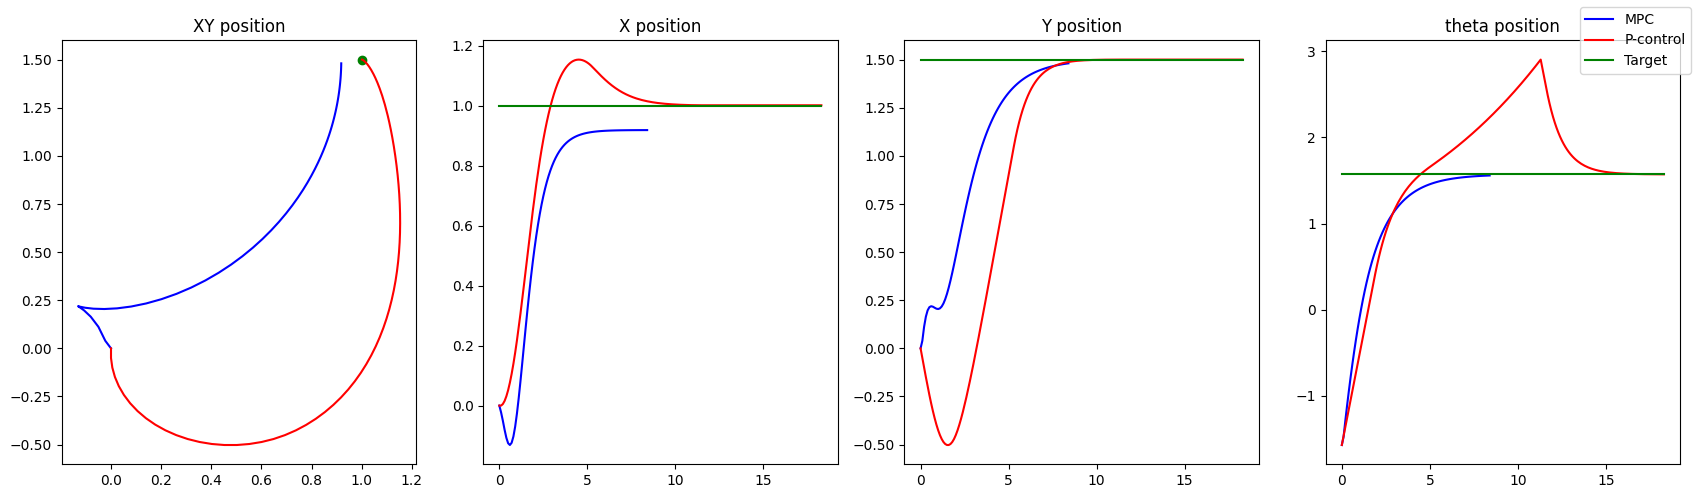

In [88]:
# plotting...
fig, axs = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches((17,5))

axs[0].plot(positions[:,0], positions[:,1], c='Blue', label='MPC')
axs[0].scatter(goal[0], goal[1], c='Green')
axs[0].plot(p_positions[:,0], p_positions[:,1], c='Red', label='P-control')
axs[0].set_title('XY position')

axs[1].plot(t_mpc, positions[:,0], c='Blue')
axs[1].plot(p_t, p_positions[:,0], c='Red')
axs[1].plot(p_t, [goal[0]] * len(p_t), c='Green', label='Target')
axs[1].set_title('X position')

axs[2].plot(t_mpc, positions[:,1], c='Blue')
axs[2].plot(p_t, p_positions[:,1], c='Red')
axs[2].plot(p_t, [goal[1]] * len(p_t), c='Green')
axs[2].set_title('Y position')

axs[3].plot(t_mpc, positions[:,2], c='Blue')
axs[3].plot(p_t, p_positions[:,2], c='Red')
axs[3].plot(p_t, [goal[2]] * len(p_t), c='Green')
axs[3].set_title('theta position')

fig.legend()

fig.tight_layout()
plt.show()
# for us in controls:
#     print(us)

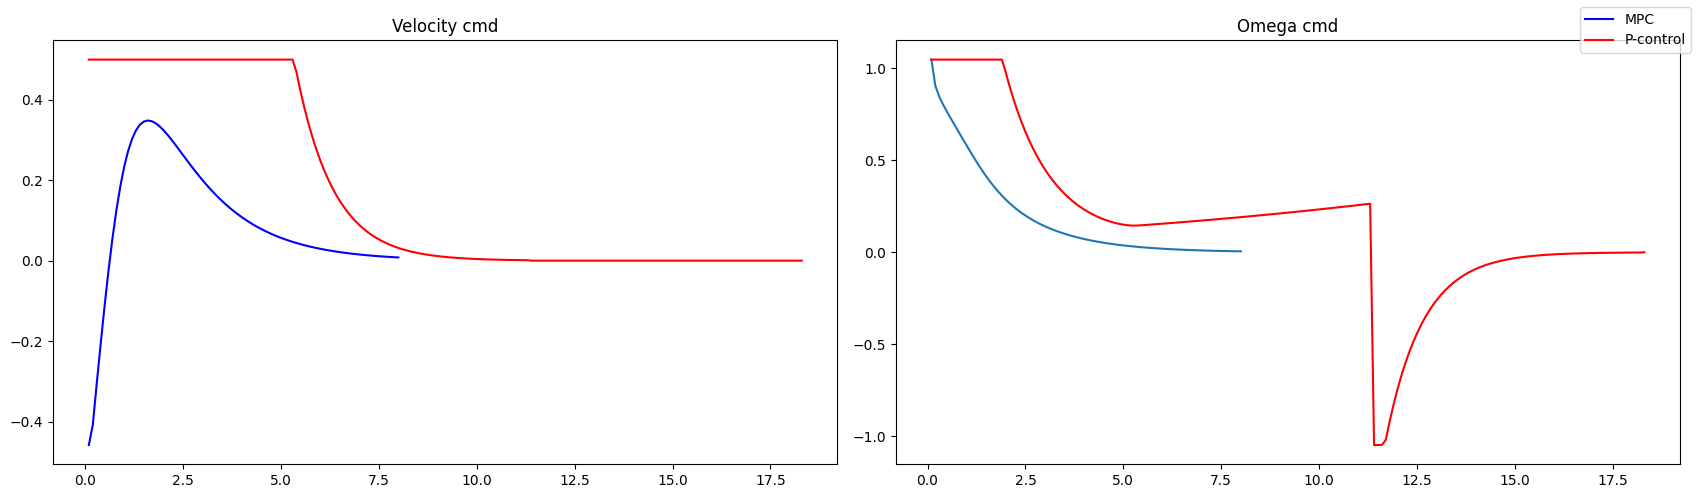

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((17,5))

axs[0].plot(t_mpc[1:], controls[:,0],c='Blue', label='MPC')
axs[0].plot(p_t[1:], p_controls[:,0],c='Red', label='P-control')
axs[0].set_title('Velocity cmd')
axs[1].plot(t_mpc[1:], controls[:,1])
axs[1].plot(p_t[1:], p_controls[:,1],c='Red')
axs[1].set_title('Omega cmd')

fig.legend()
fig.tight_layout()
plt.show()

In [ ]:
x = np.array([[1,1],[2,2]])
y = np.array([3,3])
